Connected to torch (Python 3.10.12)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

dataset = MNIST(root="~/Datasets", train=True, download=False, transform=transforms.ToTensor())
Xtsr = dataset.data.float() / 255
Xtrain = Xtsr.reshape(Xtsr.shape[0], -1)
ytrain = dataset.targets
Xtrain_norm = (Xtrain - Xtrain.mean()) / Xtrain.std()

In [2]:
# multi-head attention
ndim = 784
n_centroids = 10
n_hidden = 64
n_dot = 64
Wq = nn.Linear(ndim, n_dot)
Wk = nn.Linear(ndim, n_dot)
Wv = nn.Linear(ndim, n_hidden)
Wo = nn.Linear(n_hidden, ndim)
centroids = torch.randn(n_centroids, ndim)

In [3]:
npnts = 100
x = torch.randn(npnts, ndim)
attn = Wq(x) @ Wk(centroids).T
attn_score = F.softmax(attn / np.sqrt(n_dot), dim=1)
out = Wo(attn_score @ Wv(centroids))

In [11]:
from torch.optim import Adam
from tqdm import trange
def marginal_prob_std(t, sigma):
  """Note that this std -> 0, when t->0
  So it's not numerically stable to sample t=0 in the dataset
  Note an earlier version missed the sqrt...
  """
  return torch.sqrt( (sigma**(2*t) - 1) / 2 / torch.log(torch.tensor(sigma)) ) # sqrt fixed Jun.19


def denoise_loss_fn(model, x, marginal_prob_std_f, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability, sample t uniformly from [eps, 1.0]
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std_f(random_t,)
  perturbed_x = x + z * std[:, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=(1)))
  return loss


def train_score_td(X_train_tsr, score_model_td=None,
                   sigma=25,
                   lr=0.005,
                   nepochs=750,
                   eps=1E-3,
                   batch_size=None,
                   clipnorm=None,
                   scheduler_fun=None,):
    ndim = X_train_tsr.shape[1]
    if score_model_td is None:
        score_model_td = ScoreModel_Time_edm(sigma=sigma, ndim=ndim)
    marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)
    optim = Adam(score_model_td.parameters(), lr=lr)
    if scheduler_fun is not None:
        scheduler = scheduler_fun(optim, )
    pbar = trange(nepochs)
    for ep in pbar:
        if batch_size is None:
            loss = denoise_loss_fn(score_model_td, X_train_tsr, marginal_prob_std_f, eps=eps)
        else:
            idx = torch.randint(0, X_train_tsr.shape[0], (batch_size,))
            loss = denoise_loss_fn(score_model_td, X_train_tsr[idx], marginal_prob_std_f, eps=eps)

        optim.zero_grad()
        loss.backward()
        if clipnorm is not None:
            torch.nn.utils.clip_grad_norm_(score_model_td.parameters(),
                                           max_norm=clipnorm)
        optim.step()
        if scheduler_fun is not None:
            scheduler.step()
            pbar.set_description(f"step {ep} loss {loss.item():.3f} lr {scheduler.get_last_lr()[0]:.1e}")
        else:
            pbar.set_description(f"step {ep} loss {loss.item():.3f}")
        if ep == 0:
            print(f"step {ep} loss {loss.item():.3f}")
    return score_model_td


def reverse_diffusion_time_dep(score_model_td, sampN=500, sigma=5, nsteps=200, ndim=2, exact=False, device="cpu"):
  """
  score_model_td: if `exact` is True, use a gmm of class GaussianMixture
                  if `exact` is False. use a torch neural network that takes vectorized x and t as input.
  """
  lambdaT = (sigma**2 - 1) / (2 * np.log(sigma))
  xT = np.sqrt(lambdaT) * np.random.randn(sampN, ndim)
  x_traj_rev = np.zeros((*xT.shape, nsteps, ))
  x_traj_rev[:,:,0] = xT
  dt = 1 / nsteps
  for i in range(1, nsteps):
    t = 1 - i * dt
    tvec = torch.ones((sampN)) * t
    eps_z = np.random.randn(*xT.shape)
    if exact:
      gmm_t = diffuse_gmm(score_model_td, t, sigma)
      score_xt = gmm_t.score(x_traj_rev[:,:,i-1])
    else:
      with torch.no_grad():
        score_xt = score_model_td(torch.tensor(x_traj_rev[:,:,i-1]).float().to(device), tvec.to(device)).cpu().numpy()
    # simple Euler-Maryama integration of SGD
    x_traj_rev[:,:,i] = x_traj_rev[:,:,i-1] + eps_z * (sigma ** t) * np.sqrt(dt) + score_xt * dt * sigma**(2*t)
  return x_traj_rev


In [5]:
import math
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps.
  Basically it multiplexes a scalar `t` into a vector of `sin(2 pi k t)` and `cos(2 pi k t)` features.
  """
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

  def forward(self, t):
    t_proj = t.view(-1, 1) * self.W[None, :] * 2 * math.pi
    return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)


class DotAttention(nn.Module):
    def __init__(self, ndim, n_centroids, n_dot, n_hidden):
        super().__init__()
        self.ndim = ndim
        self.n_centroids = n_centroids
        self.n_dot = n_dot
        self.n_hidden = n_hidden
        self.Wq = nn.Linear(ndim, n_dot)
        self.Wk = nn.Linear(ndim, n_dot)
        self.Wv = nn.Linear(ndim, n_hidden)
        self.Wo = nn.Linear(n_hidden, ndim)
        self.centroids = nn.Parameter(torch.randn(n_centroids, ndim))

    def forward(self, x):
        attn = self.Wq(x) @ self.Wk(self.centroids).T
        attn_score = F.softmax(attn / np.sqrt(self.n_dot), dim=1)
        out = self.Wo(attn_score @ self.Wv(self.centroids))
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, ndim, n_centroids, n_dot, n_hidden, n_heads):
        super().__init__()
        self.ndim = ndim
        self.n_centroids = n_centroids
        self.n_dot = n_dot
        self.n_hidden = n_hidden
        self.n_heads = n_heads
        self.Wq = nn.Linear(ndim, n_dot * n_heads)
        self.Wk = nn.Linear(ndim, n_dot * n_heads)
        self.Wv = nn.Linear(ndim, n_hidden * n_heads)
        self.Wo = nn.Linear(n_hidden * n_heads, ndim)
        self.centroids = nn.Parameter(torch.randn(n_centroids, ndim))
        self.centroids.data = self.centroids.data / self.centroids.data.norm(dim=1, keepdim=True)

    def forward(self, x):
        query = self.Wq(x)
        key = self.Wk(self.centroids)
        value = self.Wv(self.centroids)
        # split heads
        query = query.reshape(query.shape[0], self.n_heads, self.n_dot)
        key = key.reshape(key.shape[0], self.n_heads, self.n_dot)
        value = value.reshape(value.shape[0], self.n_heads, self.n_hidden)
        # attention
        attn = torch.einsum("Bhd,Chd->hBC", query, key)  # head x batch x centroid
        attn_score = F.softmax(attn / np.sqrt(self.n_dot), dim=-1)  # head x batch x centroid
        head_values = torch.einsum("hBC,Chd->Bhd", attn_score, value)  # batch x head x hidden
        # merge heads
        out = self.Wo(head_values.reshape(head_values.shape[0], -1))
        return out


mha = MultiHeadAttention(ndim, n_centroids, n_dot, n_hidden, n_heads=4)
out = mha(x)

In [6]:
class ModulatedDotAttention(nn.Module):
    def __init__(self, ndim, n_centroids, n_dot, n_hidden, time_embed_dim):
        super().__init__()
        self.Wq = nn.Linear(ndim, n_dot)
        self.Wk = nn.Linear(ndim, n_dot)
        self.Wv = nn.Linear(ndim, n_hidden)
        self.Wo = nn.Linear(n_hidden, ndim)
        self.centroids = nn.Parameter(torch.randn(n_centroids, ndim))
        self.centroids.data = self.centroids.data / self.centroids.data.norm(dim=1, keepdim=True)
        self.sigma_embed = GaussianFourierProjection(time_embed_dim)
        self.sigma_mod1 = nn.Linear(time_embed_dim, n_dot)
        self.sigma_mod2 = nn.Linear(time_embed_dim, n_hidden)

    def forward(self, x, sigma):
        sigma_emb = self.sigma_embed(sigma)
        mod1 = self.sigma_mod1(sigma_emb)  # batch x n_dot
        mod2 = self.sigma_mod2(sigma_emb)  # batch x n_hidden
        attn = (self.Wq(x) * mod1) @ self.Wk(self.centroids).T
        attn_score = F.softmax(attn / np.sqrt(n_dot), dim=1)
        out = self.Wo(mod2 * (attn_score @ self.Wv(self.centroids)))
        return out


class ModulatedMultiHeadAttention(nn.Module):
    def __init__(self, ndim, n_centroids, n_dot, n_hidden, n_heads, time_embed_dim):
        super().__init__()
        self.ndim = ndim
        self.n_centroids = n_centroids
        self.n_dot = n_dot
        self.n_hidden = n_hidden
        self.n_heads = n_heads
        self.Wq = nn.Linear(ndim, n_dot * n_heads)
        self.Wk = nn.Linear(ndim, n_dot * n_heads)
        self.Wv = nn.Linear(ndim, n_hidden * n_heads)
        self.Wo = nn.Linear(n_hidden * n_heads, ndim)
        self.centroids = nn.Parameter(torch.randn(n_centroids, ndim))
        self.centroids.data = self.centroids.data / self.centroids.data.norm(dim=1, keepdim=True)
        self.sigma_embed = GaussianFourierProjection(time_embed_dim)
        self.sigma_mod1 = nn.Linear(time_embed_dim, n_dot)
        self.sigma_mod2 = nn.Linear(time_embed_dim, n_hidden)

    def forward(self, x, sigma):
        sigma_emb = self.sigma_embed(sigma)
        mod1 = self.sigma_mod1(sigma_emb)  # batch x n_dot
        mod2 = self.sigma_mod2(sigma_emb)  # batch x n_hidden
        query = self.Wq(x)
        key = self.Wk(self.centroids)
        value = self.Wv(self.centroids)
        # split heads
        query = query.reshape(query.shape[0], self.n_heads, self.n_dot)
        key = key.reshape(key.shape[0], self.n_heads, self.n_dot)
        value = value.reshape(value.shape[0], self.n_heads, self.n_hidden)
        # attention
        attn = torch.einsum("Bhd,Chd->hBC", query * mod1[:, None, :], key)  # head x batch x centroid
        attn_score = F.softmax(attn / np.sqrt(self.n_dot), dim=-1)  # head x batch x centroid
        head_values = torch.einsum("hBC,Chd->Bhd", attn_score, value)  # batch x head x hidden
        head_values = head_values * mod2[:, None, :]
        # merge heads
        out = self.Wo(head_values.reshape(head_values.shape[0], -1))
        return out

x = torch.randn(npnts, ndim)
mda = ModulatedDotAttention(ndim, n_centroids, n_dot, n_hidden, time_embed_dim=64)
out = mda(x, torch.randn(npnts))
mmha = ModulatedMultiHeadAttention(ndim, n_centroids, n_dot, n_hidden, n_heads=4, time_embed_dim=64)
out = mmha(x, torch.randn(npnts))

In [7]:
class ModulatedResBlock(nn.Module):
    def __init__(self, ndim, n_centroids, n_dot, n_hidden, n_heads,
                 mlp_proj_dim, time_embed_dim):
        super().__init__()
        self.mha = ModulatedMultiHeadAttention(ndim, n_centroids, n_dot, n_hidden, n_heads, time_embed_dim)
        self.sigma_embed = GaussianFourierProjection(time_embed_dim)
        self.sigma_gate1 = nn.Linear(time_embed_dim, 1)
        self.sigma_gate2 = nn.Linear(time_embed_dim, 1)
        self.sigma_gate3 = nn.Linear(time_embed_dim, 1)
        self.norm1 = nn.LayerNorm(ndim)
        self.norm2 = nn.LayerNorm(ndim)
        self.drop1 = nn.Dropout(0.1)
        self.drop2 = nn.Dropout(0.1)
        self.lin1 = nn.Linear(ndim, mlp_proj_dim)
        self.lin2 = nn.Linear(mlp_proj_dim, ndim)

    def forward(self, x, sigma):
        sigma_emb = self.sigma_embed(sigma)
        gate1 = self.sigma_gate1(sigma_emb)
        gate2 = self.sigma_gate2(sigma_emb)  # maybe use sigmoid
        gate3 = self.sigma_gate3(sigma_emb)
        attn = self.mha(x, sigma)
        x = self.norm1(gate1 * x + gate2 * attn)
        out = x + gate3 * F.relu(self.lin2(F.relu(self.lin1(x))))
        return out
        # x = self.norm1(x + self.drop1(attn))
        # x = self.norm2(x + self.drop2(F.relu(self.lin2(F.relu(self.lin1(x))))))
        # return x

In [8]:
class ModulatedSequential(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)

    def forward(self, x, sigma):
        for module in self:
            x = module(x, sigma)
        return x

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
resblock_cfg = {
    "ndim": Xtrain_norm.shape[1],
    "n_centroids": 32,
    "n_dot": 64,
    "n_hidden": 64,
    "n_heads": 8,
    "time_embed_dim": 128,
    "mlp_proj_dim": 512,
}
deep_mmha = ModulatedSequential(
    ModulatedResBlock(**resblock_cfg),
    ModulatedResBlock(**resblock_cfg),
    ModulatedResBlock(**resblock_cfg),
    ModulatedResBlock(**resblock_cfg),
)
device = "cuda"
deep_mmha.to(device)
Xtrain_norm = Xtrain_norm.to(device)
train_cfg = {
    "sigma": 10,
    "lr": 0.0001,
    "nepochs": 50000,
    "batch_size": 4096,
}
print("Parameter count: ", count_parameters(deep_mmha))
deep_mmha = train_score_td(Xtrain_norm, score_model_td=deep_mmha,
        **train_cfg,)
# Parameter count:  7371561
# step 0 loss 4426.592
# step 19999 loss 108.260: 100%|██████████| 20000/20000 [27:11<00:00, 12.26it/s]

Parameter count:  9828748


step 1 loss 3829.598:   0%|          | 1/50000 [00:00<1:53:37,  7.33it/s]

step 0 loss 4041.784


step 9165 loss 161.364:  18%|█▊        | 9166/50000 [03:27<15:23, 44.22it/s]


KeyboardInterrupt: 

In [ ]:
samples = reverse_diffusion_time_dep(deep_mmha, sampN=100, sigma=sigma_max, nsteps=1000, ndim=ndim, exact=False)

: 

In [12]:
train_cfg = {
    "sigma": 10,
    "lr": 0.0005,
    "nepochs": 50000,
    "batch_size": 2048,
}
deep_mmha = train_score_td(Xtrain_norm, score_model_td=deep_mmha,
        **train_cfg,)

step 12 loss 254.567:   0%|          | 13/50000 [00:00<13:54, 59.87it/s]

step 0 loss 162.720


step 49999 loss 140.564: 100%|██████████| 50000/50000 [11:30<00:00, 72.44it/s]


In [13]:
resblock_cfg = {
    "ndim": Xtrain_norm.shape[1],
    "n_centroids": 32,
    "n_dot": 64,
    "n_hidden": 64,
    "n_heads": 8,
    "time_embed_dim": 128,
    "mlp_proj_dim": 512,
}
deep_mmha = ModulatedSequential(
    ModulatedResBlock(**resblock_cfg),
    ModulatedResBlock(**resblock_cfg),
    # ModulatedResBlock(**resblock_cfg),
    # ModulatedResBlock(**resblock_cfg),
)
device = "cuda"
deep_mmha.to(device)
Xtrain_norm = Xtrain_norm.to(device)
train_cfg = {
    "sigma": 10,
    "lr": 0.001,
    "nepochs": 50000,
    "batch_size": 8192,
}
print("Parameter count: ", count_parameters(deep_mmha))
deep_mmha = train_score_td(Xtrain_norm, score_model_td=deep_mmha,
        **train_cfg,)
# Parameter count:  7371561
# step 0 loss 4426.592
# step 19999 loss 108.260: 100%|██████████| 20000/20000 [27:11<00:00, 12.26it/s]

Parameter count:  4914374


step 6 loss 3752.783:   0%|          | 4/50000 [00:00<21:56, 37.97it/s]

step 0 loss 4177.326


step 49999 loss 107.973: 100%|██████████| 50000/50000 [17:39<00:00, 47.17it/s]


In [14]:
resblock_cfg = {
    "ndim": Xtrain_norm.shape[1],
    "n_centroids": 32,
    "n_dot": 64,
    "n_hidden": 64,
    "n_heads": 8,
    "time_embed_dim": 128,
    "mlp_proj_dim": 512,
}
deep_mmha = ModulatedSequential(
    ModulatedResBlock(**resblock_cfg),
    ModulatedResBlock(**resblock_cfg),
    # ModulatedResBlock(**resblock_cfg),
    # ModulatedResBlock(**resblock_cfg),
)
device = "cuda"
deep_mmha.to(device)
Xtrain_norm = Xtrain_norm.to(device)
train_cfg = {
    "sigma": 10,
    "lr": 0.0005,
    "nepochs": 50000,
    "batch_size": 8192,
}
print("Parameter count: ", count_parameters(deep_mmha))
deep_mmha = train_score_td(Xtrain_norm, score_model_td=deep_mmha,
        **train_cfg,)
# Parameter count:  7371561
# step 0 loss 4426.592
# step 19999 loss 108.260: 100%|██████████| 20000/20000 [27:11<00:00, 12.26it/s]

Parameter count:  4914374


step 6 loss 4396.703:   0%|          | 4/50000 [00:00<21:54, 38.02it/s]

step 0 loss 4665.382


step 4221 loss 162.368:   8%|▊         | 4222/50000 [01:29<16:10, 47.19it/s]


KeyboardInterrupt: 

In [15]:
resblock_cfg = {
    "ndim": Xtrain_norm.shape[1],
    "n_centroids": 64,
    "n_dot": 64,
    "n_hidden": 64,
    "n_heads": 4,
    "time_embed_dim": 128,
    "mlp_proj_dim": 1024,
}
deep_mmha = ModulatedSequential(
    ModulatedResBlock(**resblock_cfg),
    ModulatedResBlock(**resblock_cfg),
    # ModulatedResBlock(**resblock_cfg),
    # ModulatedResBlock(**resblock_cfg),
)
device = "cuda"
deep_mmha.to(device)
Xtrain_norm = Xtrain_norm.to(device)
train_cfg = {
    "sigma": 10,
    "lr": 0.001,
    "nepochs": 50000,
    "batch_size": 8192,
}
print("Parameter count: ", count_parameters(deep_mmha))
deep_mmha = train_score_td(Xtrain_norm, score_model_td=deep_mmha,
        **train_cfg,)
# Parameter count:  7371561
# step 0 loss 4426.592
# step 19999 loss 108.260: 100%|██████████| 20000/20000 [27:11<00:00, 12.26it/s]

Parameter count:  4964038


step 5 loss 3901.008:   0%|          | 4/50000 [00:00<24:13, 34.40it/s]

step 0 loss 4296.928


step 30580 loss 107.169:  61%|██████    | 30581/50000 [11:57<07:35, 42.63it/s]


KeyboardInterrupt: 

In [12]:
from torch.optim.lr_scheduler import CosineAnnealingLR
resblock_cfg = {
    "ndim": Xtrain_norm.shape[1],
    "n_centroids": 64,
    "n_dot": 64,
    "n_hidden": 64,
    "n_heads": 4,
    "time_embed_dim": 128,
    "mlp_proj_dim": 1024,
}
deep_mmha = ModulatedSequential(
    ModulatedResBlock(**resblock_cfg),
    ModulatedResBlock(**resblock_cfg),
    # ModulatedResBlock(**resblock_cfg),
    # ModulatedResBlock(**resblock_cfg),
)
device = "cuda"
deep_mmha.to(device)
Xtrain_norm = Xtrain_norm.to(device)
train_cfg = {
    "sigma": 10,
    "lr": 0.001,
    "nepochs": 100000,
    "batch_size": 16384,
}
scheduler_fun = lambda optim: CosineAnnealingLR(optim, T_max=train_cfg["nepochs"], eta_min=1e-5)
print("Parameter count: ", count_parameters(deep_mmha))
deep_mmha = train_score_td(Xtrain_norm, score_model_td=deep_mmha,
        scheduler_fun=scheduler_fun, **train_cfg,)
# Parameter count:  7371561
# step 0 loss 4426.592
# step 19999 loss 108.260: 100%|██████████| 20000/20000 [27:11<00:00, 12.26it/s]

Parameter count:  4964038


  0%|          | 0/100000 [00:00<?, ?it/s]

step 2 loss 4193.592 lr 1.0e-03:   0%|          | 2/100000 [00:00<1:31:48, 18.15it/s]

step 0 loss 4575.008


step 99999 loss 76.364 lr 1.0e-05: 100%|██████████| 100000/100000 [1:13:53<00:00, 22.56it/s]


In [13]:
train_cfg = {
    "sigma": 10,
    "lr": 0.0001,
    "nepochs": 100000,
    "batch_size": 16384,
}
scheduler_fun = lambda optim: CosineAnnealingLR(optim, T_max=train_cfg["nepochs"], eta_min=1e-5)
print("Parameter count: ", count_parameters(deep_mmha))
deep_mmha = train_score_td(Xtrain_norm, score_model_td=deep_mmha,
        scheduler_fun=scheduler_fun, **train_cfg,)

Parameter count:  4964038


step 3 loss 81.480 lr 1.0e-04:   0%|          | 3/100000 [00:00<1:14:10, 22.47it/s]

step 0 loss 77.289


step 99999 loss 75.652 lr 1.0e-05: 100%|██████████| 100000/100000 [1:13:54<00:00, 22.55it/s]


In [15]:
import json
torch.save(deep_mmha.state_dict(), "deep2l_mmha.pt")
json.dump(resblock_cfg, open("deep2l_mmha_cfg.json", "w"))
json.dump(train_cfg, open("deep2l_mmha_train_cfg.json", "w"))

In [16]:
from torch.optim.lr_scheduler import CosineAnnealingLR
resblock_cfg = {
    "ndim": Xtrain_norm.shape[1],
    "n_centroids": 64,
    "n_dot": 64,
    "n_hidden": 64,
    "n_heads": 4,
    "time_embed_dim": 128,
    "mlp_proj_dim": 1024,
}
deep_mmha = ModulatedSequential(
    ModulatedResBlock(**resblock_cfg),
    ModulatedResBlock(**resblock_cfg),
    ModulatedResBlock(**resblock_cfg),
    ModulatedResBlock(**resblock_cfg),
    ModulatedResBlock(**resblock_cfg),
    ModulatedResBlock(**resblock_cfg),
)
device = "cuda"
deep_mmha.to(device)
Xtrain_norm = Xtrain_norm.to(device)
train_cfg = {
    "sigma": 10,
    "lr": 0.001,
    "nepochs": 100000,
    "batch_size": 16384,
}
scheduler_fun = lambda optim: CosineAnnealingLR(optim, T_max=train_cfg["nepochs"], eta_min=1e-5)
print("Parameter count: ", count_parameters(deep_mmha))
deep_mmha = train_score_td(Xtrain_norm, score_model_td=deep_mmha,
        scheduler_fun=scheduler_fun, **train_cfg,)

Parameter count:  14892114


step 1 loss 4138.110 lr 1.0e-03:   0%|          | 2/100000 [00:00<5:41:39,  4.88it/s]

step 0 loss 4329.709


step 99999 loss 66.872 lr 1.0e-05: 100%|██████████| 100000/100000 [3:38:20<00:00,  7.63it/s]  


In [20]:
import json
torch.save(deep_mmha.state_dict(), "deep6l_mmha.pt")
json.dump(resblock_cfg, open("deep6l_mmha_cfg.json", "w"))
json.dump(train_cfg, open("deep6l_mmha_train_cfg.json", "w"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


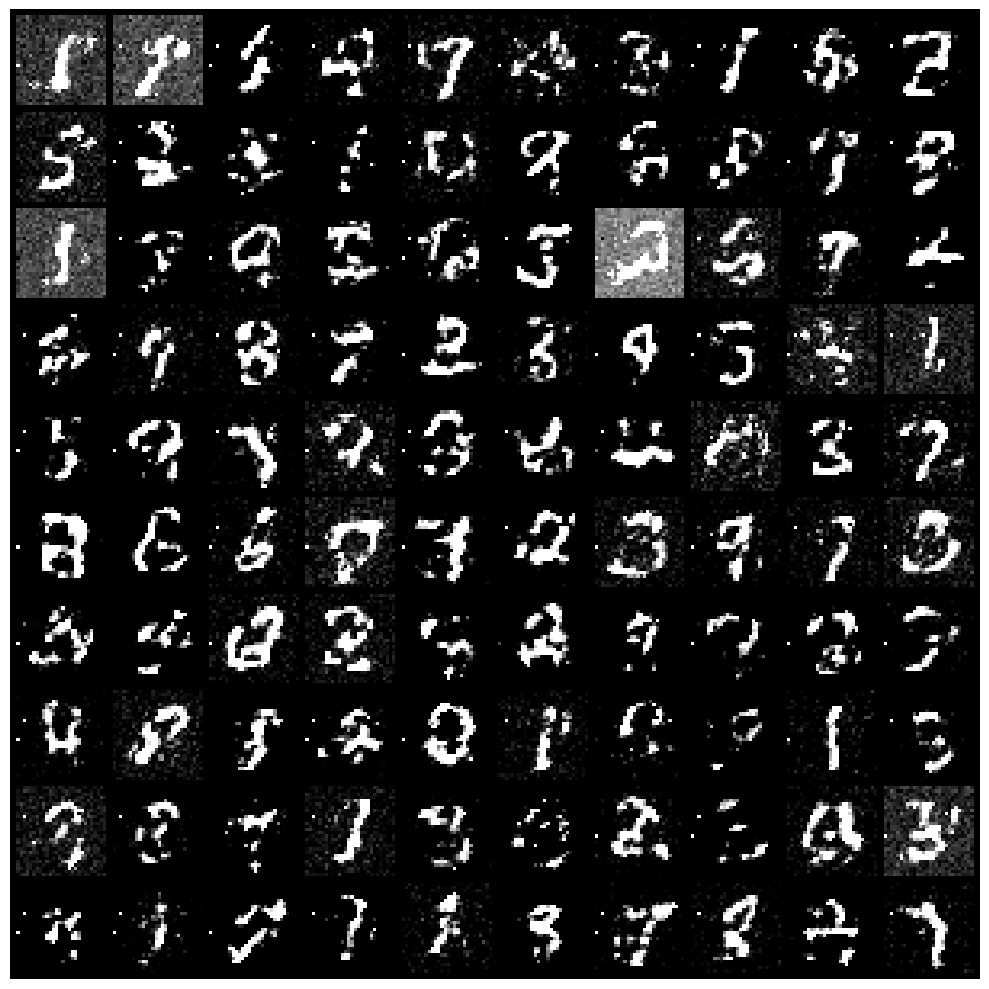

In [19]:
samples = reverse_diffusion_time_dep(deep_mmha, sampN=100, sigma=train_cfg["sigma"], nsteps=1000, ndim=ndim, exact=False, device="cuda")
#%%
mtg = make_grid(torch.from_numpy(samples[:,:,-1].reshape(-1, 1, 28, 28)), nrow=10)
plt.figure(figsize=[10, 10])
plt.imshow(mtg.permute(1, 2, 0))
plt.axis("off")
plt.tight_layout()
plt.show()

In [21]:
train_cfg = {
    "sigma": 10,
    "lr": 0.00005,
    "nepochs": 100000,
    "batch_size": 16384,
}
scheduler_fun = lambda optim: CosineAnnealingLR(optim, T_max=train_cfg["nepochs"], eta_min=1e-5)
print("Parameter count: ", count_parameters(deep_mmha))
deep_mmha = train_score_td(Xtrain_norm, score_model_td=deep_mmha,
        scheduler_fun=scheduler_fun, **train_cfg,)

Parameter count:  14892114


step 0 loss 65.812 lr 5.0e-05:   0%|          | 1/100000 [00:00<3:39:49,  7.58it/s]

step 0 loss 65.812


step 99999 loss 63.780 lr 1.0e-05: 100%|██████████| 100000/100000 [3:38:13<00:00,  7.64it/s] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


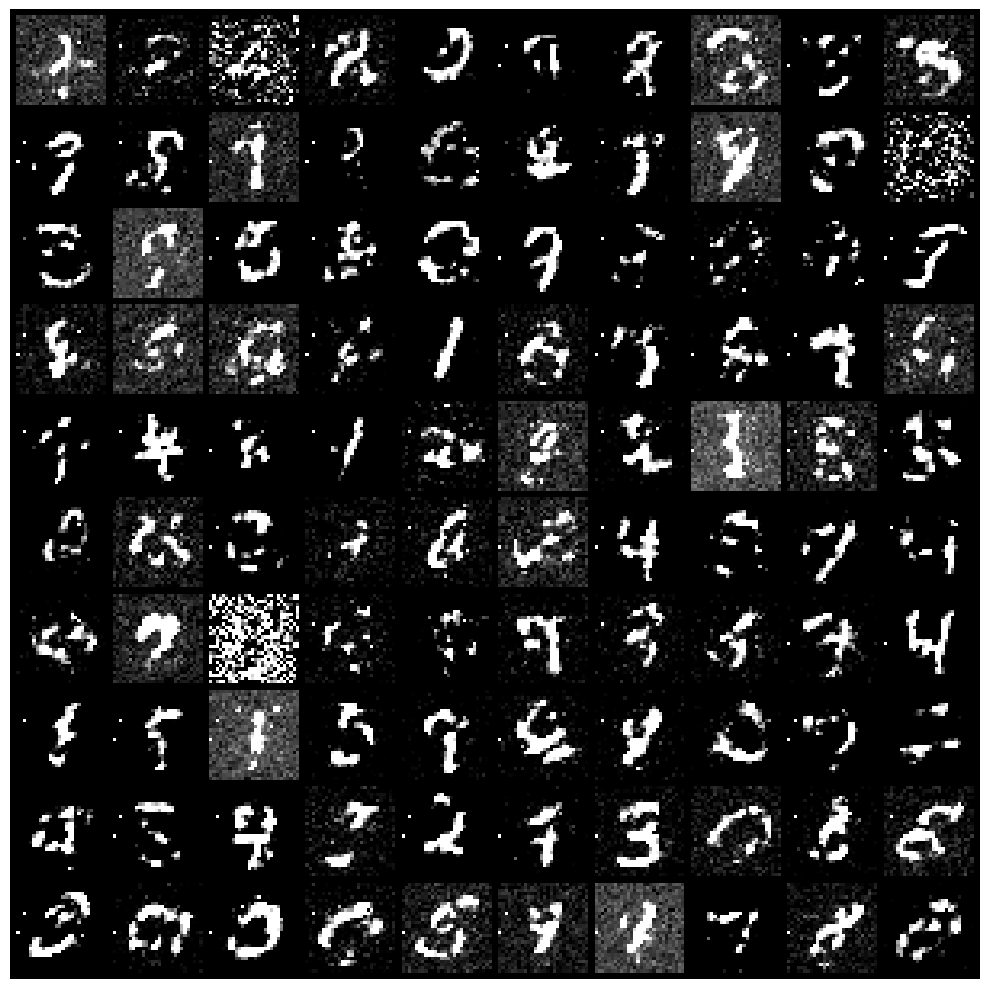

In [22]:
samples = reverse_diffusion_time_dep(deep_mmha, sampN=100, sigma=train_cfg["sigma"], nsteps=1000, ndim=ndim, exact=False, device="cuda")
#%%
mtg = make_grid(torch.from_numpy(samples[:,:,-1].reshape(-1, 1, 28, 28)), nrow=10)
plt.figure(figsize=[10, 10])
plt.imshow(mtg.permute(1, 2, 0))
plt.axis("off")
plt.tight_layout()
plt.show()